# GoogLeNet: winner on ImageNet in 2014

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# Inception Blocks

In [2]:
class Inception(nn.Module):
    # `c1` -- `c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is 1 x 1 convolutional layer followed by a 3 x 3 convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5 convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1 convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the output on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

# GooLeNet

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [4]:
b2 = nn.Sequential(
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [5]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    # in_channels: 64 + 128 + 32 + 32 = 256
    Inception(256, 128, (128, 192), (32, 96), 64), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [6]:
b4 = nn.Sequential(
    # in_channels: 128 + 192 + 96 + 64 = 480
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [7]:
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [8]:
# 384 + 384 + 128 + 128 = 1024
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [9]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(f'{layer.__class__.__name__:<10} output shape:\t {X.shape}')

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear     output shape:	 torch.Size([1, 10])


loss 0.254, train acc 0.904, test acc 0.898
29.8 examples/sec on cpu


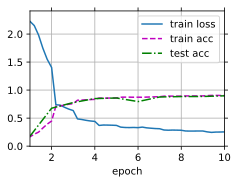

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())